This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image, an autoencoder first encodes it into a lower dimensional latent representation, then decodes the latent representation back into the image. In the scenario, an autoencoder learns to compress the data while minimizing the reconstruction error.

In [1]:
import logging
logging.basicConfig(level=logging.INFO, 
                    format="%(asctime)s-%(levelname)s: %(message)s")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
logging.info("Tensorflow Version: {}".format(tf.__version__))
logging.info("GPU is{} available.".format("" if tf.config.experimental.list_physical_devices("GPU") else " not"))

2021-02-02 05:16:55,362-INFO: Tensorflow Version: 2.4.1
2021-02-02 05:16:56,607-INFO: GPU is available.


# Load the dataset

In the first two examples, you are going to use the `fashion_mnist` dataset that consists of 10 classes of images with 60,000 training images and 10,000 testing images.

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(xTrain, _), (xTest, _) = fashion_mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') /255.

print(xTrain.shape, xTest.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


# First Example: Basic Autoencoder

Basically, there are two components, `encoder` and `decoder`, in the autoencoder. In the example, the autoencoder compresses the image into a fixed-length dimensional latent vector using `encoder`, and then reconstructs the latent vector back into the image using `decoder`.


In [3]:
class Autoencoder(tf.keras.models.Model):
  def __init__(self, latentDimension=32):
    super(Autoencoder, self).__init__()
    self.latentDimension = latentDimension
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latentDimension, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(784, activation='sigmoid'),
      tf.keras.layers.Reshape(target_shape=(28, 28))
    ])
  
  def call(self, x):
    encoded = self.encoder(x)
    y = self.decoder(encoded)
    return y

latentDimension = 64
autoencoder = Autoencoder(latentDimension=latentDimension)

In [4]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), 
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanSquaredError()])

In [5]:
history = autoencoder.fit(xTrain, xTrain,
                          epochs=50,
                          shuffle=True,
                          validation_data=(xTest, xTest),
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 7/50
1875/

In [6]:
autoencoder.encoder.summary(), autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               50960     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


(None, None)

In [7]:
encodedImages = autoencoder.encoder(xTest).numpy()
decodedImages = autoencoder.decoder(encodedImages).numpy()

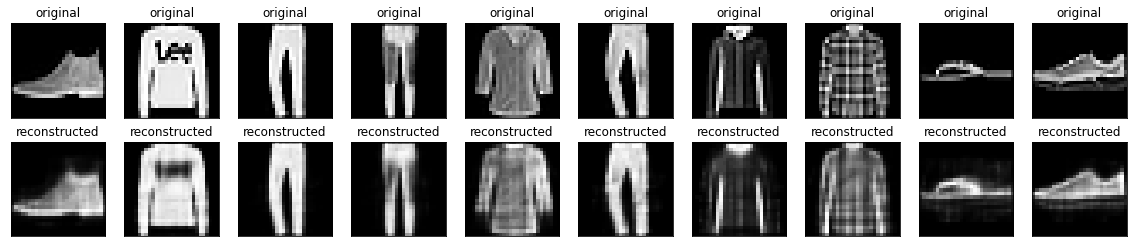

In [8]:
num = 10
plt.figure(figsize=(20, 4))
for i in range(num):
  # original
  ax = plt.subplot(2, num, i+1)
  plt.imshow(xTest[i])
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # reconstructed
  ax = plt.subplot(2, num, i+1+num)
  plt.imshow(decodedImages[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Second Example: Image Denoising

The autoencoder can be also trained to remove the noise from images. You can create a noisy version of fashion mnist image dataset by random applying noise to each image and then train a model to recover it to the original image.

In [9]:
(xTrain, _), (xTest, _) = fashion_mnist.load_data()

xTrain = xTrain.astype("float32") / 255.0
xTest = xTest.astype("float32") / 255.0

xTrain = xTrain[..., tf.newaxis]
xTest = xTest[..., tf.newaxis]

print(xTrain.shape, xTest.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [10]:
noiseFactor = 0.2

xTrainNoisy = xTrain + noiseFactor * tf.random.normal(shape=xTrain.shape)
xTestNoisy = xTest + noiseFactor * tf.random.normal(shape=xTest.shape)

xTrainNoisy = tf.clip_by_value(xTrainNoisy, clip_value_min=0., clip_value_max=1.)
xTestNoisy = tf.clip_by_value(xTestNoisy, clip_value_min=0., clip_value_max=1.)

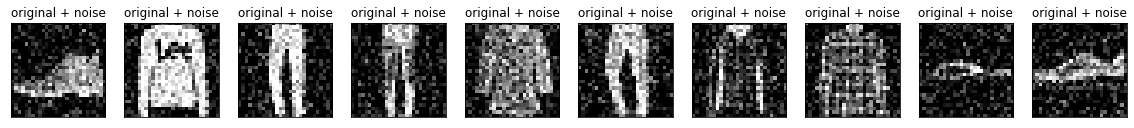

In [11]:
num = 10
plt.figure(figsize=(20, 2))
for i in range(num):
  ax = plt.subplot(1, num, i+1)
  ax.set_title("original + noise")
  ax.imshow(tf.squeeze(xTestNoisy[i], axis=-1))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()
plt.show()

In this example, you are going to create a CNN-based autoencoder.

In [12]:
class Denoise(tf.keras.models.Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', strides=(2,2)),
      tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', strides=(2,2))
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3,3), padding='same', strides=(2,2), activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same', strides=(2,2), activation='relu'),
      tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    y = self.decoder(encoded)
    return y

autoencoder = Denoise()

In [13]:
autoencoder.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [14]:
history = autoencoder.fit(
  x=xTrainNoisy, y=xTrain,
  epochs=50,
  shuffle=True,
  validation_data=(xTestNoisy, xTest),
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
1875/1875 [==============================] - 11s 3ms/step - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 2/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 7/50
1875

In [15]:
autoencoder.encoder.summary(), autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable 

(None, None)

In [16]:
encodedImages = autoencoder.encoder.predict(xTestNoisy)
decodedImages = autoencoder.decoder.predict(encodedImages)

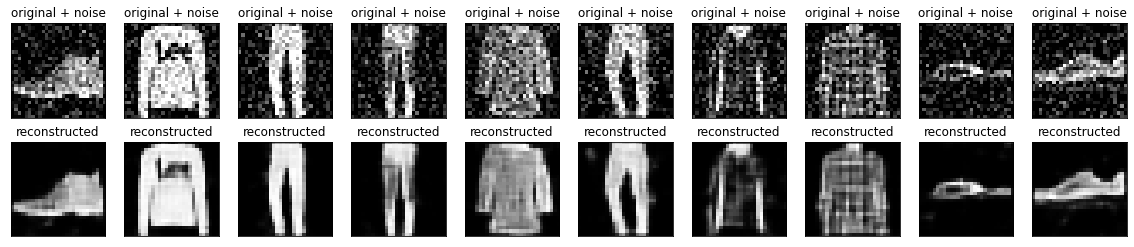

In [17]:
num = 10
plt.figure(figsize=(20, 4))
for i in range(num):
  # original
  ax = plt.subplot(2, num, i+1)
  plt.imshow(tf.squeeze(xTestNoisy[i], axis=-1))
  plt.title('original + noise')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # reconstructed
  ax = plt.subplot(2, num, i+1+num)
  plt.imshow(tf.squeeze(decodedImages[i], axis=-1))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Third Example: Anomaly Detection

In this example, you are going to detect the anomalies on the [ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) dataset. The dataset contains 5,000 electrocardiograms, each with 140 data points. Here you are going to use the simplified version of the dataset, where each example has been labeled either `0` (abnormal rhythm), or `1` (normal rhythm). The goal is to find out the abnormal rhythms.

**This example shows an approach of the classification of extremely imblance dataset, where you don't have labels available, or you have plenty of normal cases but a mall number of abnormal cases.**

How will you detect anomalies using an autoencoder? The autoencoder is trained to minimize the reconstruction error. You will train an autoencoder on normal rhythms only, then use it to reconstruct the data. The hypothesis is that the abnormal rhythms will have higher reconstruction error. You will classify a rhythm as an anomaly if the reconstruction error surpasses a threshold.

## Load ECG Dataset

The first 140 column data are features and the last 1 column data is the tag, where the tag `0` is abnormal and tag `1` is normal. 

In [18]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', 
                        header=None)
rawData = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [19]:
labels = rawData[:, -1]
data = rawData[:, 0:-1]

trainData, testData, trainLabels, testLabels = train_test_split(data, labels, 
                                                                test_size=0.2,
                                                                random_state=1)
trainData.shape, trainLabels.shape

((3998, 140), (3998,))

Normalize the dataset.

In [20]:
minVal = tf.reduce_min(trainData)
maxVal = tf.reduce_max(trainData)

trainData = (trainData - minVal) / (maxVal - minVal)
testData = (testData - minVal) / (maxVal - minVal)

trainData = tf.cast(trainData, tf.float32)
testData = tf.cast(testData, tf.float32)

trainLabels = tf.cast(trainLabels, bool)
testLabels = tf.cast(testLabels, bool)

You will train an autoencoder on the normal rhythms only. Seperate the normal ones from the abnormal ones.

In [21]:
normalTrainData = trainData[trainLabels]
normalTestData = testData[testLabels]

abnormalTrainData = trainData[~trainLabels]
abnormalTestData = testData[~testLabels]

normalTrainData.shape, abnormalTrainData.shape

(TensorShape([2327, 140]), TensorShape([1671, 140]))

Let's look at the dataset.

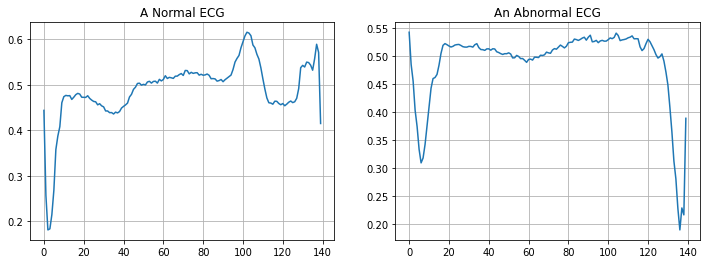

In [22]:
fig = plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,1)
ax.grid()
ax.plot(np.arange(140), normalTrainData[0])
ax.set_title("A Normal ECG")

ax = plt.subplot(1,2,2)
ax.grid()
ax.plot(np.arange(140), abnormalTrainData[0])
ax.set_title("An Abnormal ECG")

plt.show()

## Build the Model

In [23]:
class AnomalyDetector(tf.keras.models.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),      
      tf.keras.layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    y = self.decoder(encoded)
    return y

In [24]:
autoencoder = AnomalyDetector()

autoencoder.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.MeanAbsoluteError(),
  metrics=tf.keras.metrics.MeanAbsoluteError()
)

history = autoencoder.fit(
    normalTrainData, normalTrainData,
    epochs=1000,
    batch_size=1024,
    shuffle=True,
    validation_data=(normalTestData, normalTestData),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=10)])

Epoch 1/1000
3/3 [==============================] - 1s 82ms/step - loss: 0.0495 - mean_absolute_error: 0.0495 - val_loss: 0.0464 - val_mean_absolute_error: 0.0464
Epoch 2/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0452 - val_mean_absolute_error: 0.0452
Epoch 3/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0450 - mean_absolute_error: 0.0450 - val_loss: 0.0443 - val_mean_absolute_error: 0.0443
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434
Epoch 5/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0431 - mean_absolute_error: 0.0431 - val_loss: 0.0424 - val_mean_absolute_error: 0.0424
Epoch 6/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 7/1000
3/3 [====

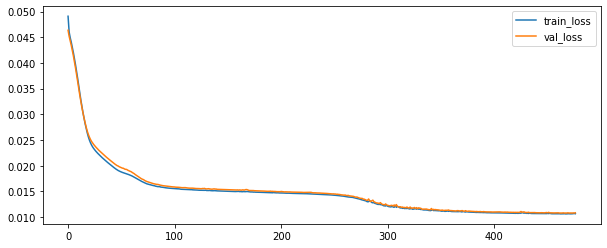

In [26]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.plot(history.epoch, history.history["loss"], label="train_loss")
ax.plot(history.epoch, history.history["val_loss"], label="val_loss")
ax.legend()
plt.show()

After training, you now can classify an ECG as anomalous if the reconstruction error is greater than one or even two standard deviation from the normal training examples.
Let's first plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstructor error.

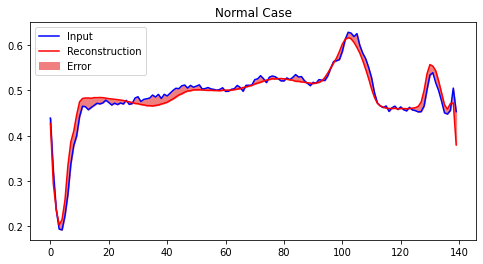

In [34]:
encoded = autoencoder.encoder.predict(normalTestData[:1])
decoded = autoencoder.decoder.predict(encoded)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,1,1)
ax.plot(normalTestData[0], 'b')
ax.plot(decoded[0], 'r')
ax.set_title("Normal Case")
ax.fill_between(np.arange(140), normalTestData[0], decoded[0], color='lightcoral')
ax.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Let's look at the anomalous.

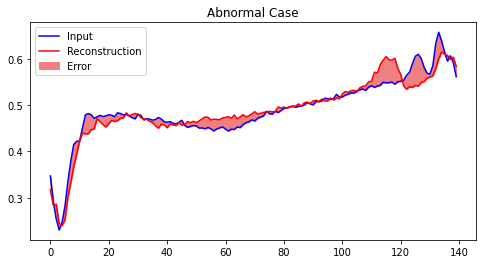

In [35]:
encoded = autoencoder.encoder.predict(abnormalTestData[:1])
decoded = autoencoder.decoder.predict(encoded)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,1,1)
ax.plot(abnormalTestData[0], 'b')
ax.plot(decoded[0], 'r')
ax.set_title("Abnormal Case")
ax.fill_between(np.arange(140), abnormalTestData[0], decoded[0], color='lightcoral')
ax.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Detect Anomalies

Detect anomalies by calculating whether the reconstruction error is greater than a threshold.

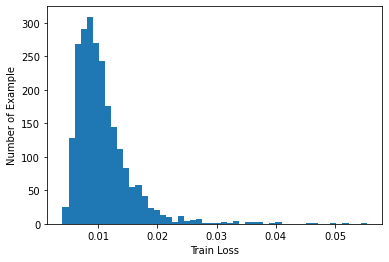

In [37]:
reconstructions = autoencoder.predict(normalTrainData)
trainLoss = tf.keras.losses.mae(reconstructions, normalTrainData)

plt.hist(trainLoss, bins=50)
plt.xlabel("Train Loss")
plt.ylabel("Number of Example")
plt.show()

The above plot shows the mean average error between the normal and its reconstruction meets the normal distribution.

In [39]:
threshold = np.mean(trainLoss) + np.std(trainLoss)
"The threshold is {}.".format(threshold)

'The threshold is 0.015454914420843124.'

## Evaluation

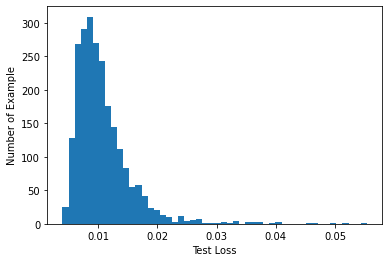

In [40]:
reconstructions = autoencoder.predict(abnormalTestData)
testLoss = tf.keras.losses.mae(abnormalTestData, reconstructions)

plt.hist(trainLoss, bins=50)
plt.xlabel("Test Loss")
plt.ylabel("Number of Example")
plt.show()

In [43]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  losses = tf.keras.losses.mae(data, reconstructions)
  return tf.math.less(losses, threshold)

def evaluation(labels, predictions):
  print("Accuracy: {}".format(accuracy_score(labels, predictions)))
  print("Precision: {}".format(precision_score(labels, predictions)))
  print("Recall: {}".format(recall_score(labels, predictions)))

preds = predict(autoencoder, testData, threshold)
evaluation(testLabels, preds)

Accuracy: 0.921
Precision: 0.9961315280464217
Recall: 0.8699324324324325
